# Introduction to GIS
## A tutorial with GeoPandas in Python
### By Yueyan Wang 10-12-2017

In [1]:
%matplotlib inline 
import geopandas as gpd
import matplotlib.pyplot as plt

# read files and basic mapping

In [2]:
#read country GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
# Examine country GeoDataFrame
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


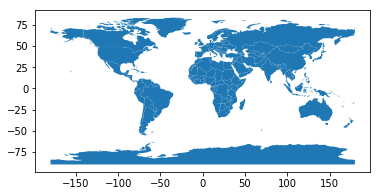

In [4]:
#basic plot, with random colors
world.plot()

coordinate indexing and selecting data

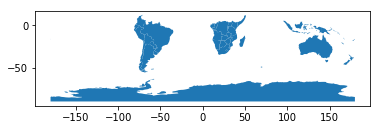

In [5]:
#plot only the Southern Hemisphere
southern_world = world.cx[:,:0]
southern_world.plot()

some mapping tools

In [6]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [7]:
cities.head()

,name,geometry
0,Vatican City,POINT (12.45338654497177 41.90328217996012)
1,San Marino,POINT (12.44177015780014 43.936095834768)
2,Vaduz,POINT (9.516669472907267 47.13372377429357)
3,Luxembourg,POINT (6.130002806227083 49.61166037912108)
4,Palikir,POINT (158.1499743237623 6.916643696007725)


# Choropleth Maps

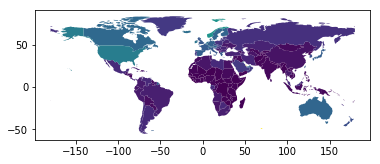

In [8]:
# Plot by GDP per capta
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world.plot(column='gdp_per_cap')

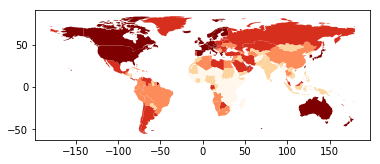

In [9]:
#choose colors
world.plot(column='gdp_per_cap', cmap='OrRd', scheme='quantiles')

In [10]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,gdp_per_cap
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",0.000784
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,0.008618
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",0.005993
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",0.038408
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,0.014027


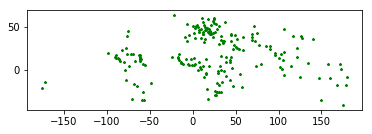

In [11]:
#plot cities (captials)
cities.plot(marker='*', color='green', markersize=5);
# Check crs
cities = cities.to_crs(world.crs)

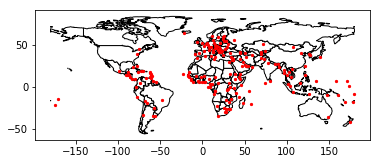

In [12]:
#overlay cities over country outlines
base = world.plot(color='white', edgecolor='black')
cities.plot(ax=base, marker='o', color='red', markersize=5)

# projections

In [13]:
# Check original projection
world.crs

{'init': 'epsg:4326'}

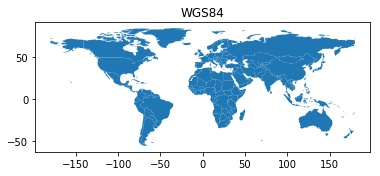

In [14]:
# Visualize of the initial projection
ax = world.plot()
ax.set_title("WGS84")

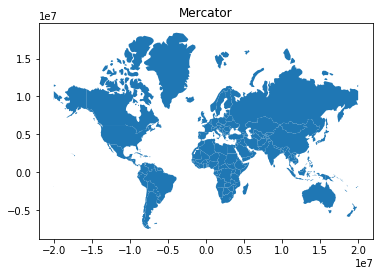

In [15]:
# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

#reprojecting
world = world.to_crs({'init': 'epsg:3395'}) # world.to_crs(epsg=3395) would also work

# Visualize of the new projection
ax = world.plot()
ax.set_title("Mercator")

# Set-Operations with Overlay

In [16]:
#create polygons
from shapely.geometry import Polygon
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]), Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]), Polygon([(3,3), (5,3), (5,5), (3,5)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

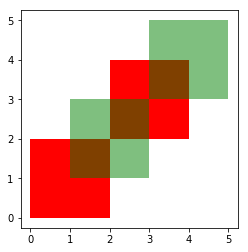

In [17]:
# Visualize of the two polygons
ax = df1.plot(color='red');
df2.plot(ax=ax, color='green', alpha=0.5)

In [18]:
#union
res_union = gpd.overlay(df1, df2, how='union')
res_union

,df1,df2,geometry
0,1.0,NaN,"POLYGON ((2 1, 2 0, 0 0, 0 2, 1 2, 1 1, 2 1))"
1,1.0,1.0,"POLYGON ((2 1, 1 1, 1 2, 2 2, 2 1))"
2,NaN,1.0,"POLYGON ((2 1, 2 2, 3 2, 3 1, 2 1))"
3,NaN,1.0,"POLYGON ((2 2, 1 2, 1 3, 2 3, 2 2))"
4,2.0,NaN,"POLYGON ((3 2, 3 3, 4 3, 4 2, 3 2))"
5,2.0,1.0,"POLYGON ((3 3, 3 2, 2 2, 2 3, 3 3))"
6,2.0,NaN,"POLYGON ((3 3, 2 3, 2 4, 3 4, 3 3))"
7,NaN,2.0,"POLYGON ((4 3, 4 4, 3 4, 3 5, 5 5, 5 3, 4 3))"
8,2.0,2.0,"POLYGON ((3 4, 4 4, 4 3, 3 3, 3 4))"


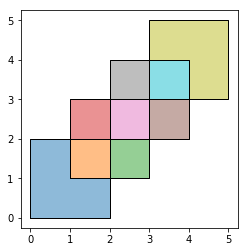

In [19]:
# Visualize
ax = res_union.plot(alpha=0.5, cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

In [20]:
#intersection
res_intersection = gpd.overlay(df1, df2, how='intersection')
res_intersection

,df1,df2,geometry
0,1,1,"POLYGON ((2 1, 1 1, 1 2, 2 2, 2 1))"
1,2,1,"POLYGON ((3 3, 3 2, 2 2, 2 3, 3 3))"
2,2,2,"POLYGON ((3 4, 4 4, 4 3, 3 3, 3 4))"


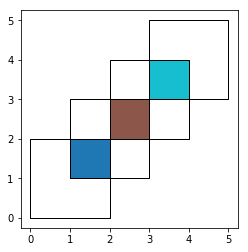

In [21]:
# Visualize
ax = res_intersection.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

In [22]:
#symmetric_difference
res_symdiff = gpd.overlay(df1, df2, how='symmetric_difference')
res_symdiff

,df1,df2,geometry
0,1.0,NaN,"POLYGON ((2 1, 2 0, 0 0, 0 2, 1 2, 1 1, 2 1))"
1,NaN,1.0,"POLYGON ((2 1, 2 2, 3 2, 3 1, 2 1))"
2,NaN,1.0,"POLYGON ((2 2, 1 2, 1 3, 2 3, 2 2))"
3,2.0,NaN,"POLYGON ((3 2, 3 3, 4 3, 4 2, 3 2))"
4,2.0,NaN,"POLYGON ((3 3, 2 3, 2 4, 3 4, 3 3))"
5,NaN,2.0,"POLYGON ((4 3, 4 4, 3 4, 3 5, 5 5, 5 3, 4 3))"


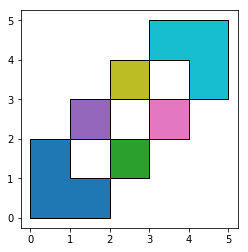

In [23]:
# Visualize
ax = res_symdiff.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

In [24]:
#difference
res_difference = gpd.overlay(df1, df2, how='difference')
res_difference

,df1,df2,geometry
0,1,None,"POLYGON ((2 1, 2 0, 0 0, 0 2, 1 2, 1 1, 2 1))"
1,2,None,"POLYGON ((3 2, 3 3, 4 3, 4 2, 3 2))"
2,2,None,"POLYGON ((3 3, 2 3, 2 4, 3 4, 3 3))"


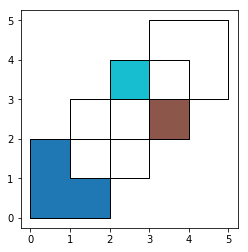

In [25]:
# Visualize
ax = res_difference.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

Overlay example

In [26]:
# Select South Amarica and then select geometry and name columns
countries = world[world['continent'] == "South America"]
countries = countries[['geometry', 'name']]

# Project to crs that uses meters as distance measure
countries = countries.to_crs('+init=epsg:3395')
capitals = cities.to_crs('+init=epsg:3395')

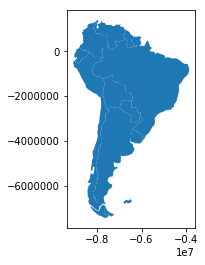

In [27]:
#check countries: World Mercator, units of meters
countries.plot()

In [28]:
#check CRS of capitals: World Mercator, units of meters
capitals.crs

'+init=epsg:3395'

In [29]:
#buffer cities to find area within 500 km
capitals['geometry']= capitals.buffer(500000)

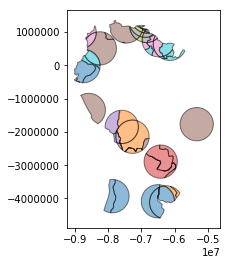

In [30]:
#intersection with countries
country_cores = gpd.overlay(countries, capitals, how='intersection')
country_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10')

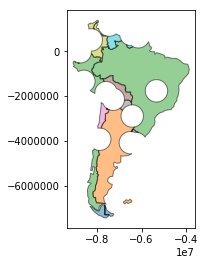

In [31]:
#difference with countries
country_peripheries = gpd.overlay(countries, capitals, how='difference')
country_peripheries.plot(alpha=0.5, edgecolor='k', cmap='tab10')

# Aggregation countries to continents

In [32]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[['continent', 'geometry']]
continents = world.dissolve(by='continent')
continents.head()

,geometry
continent,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...
Antarctica,(POLYGON ((-159.2081835601977 -79.497059421708...
Asia,(POLYGON ((120.7156087586305 -10.2395813940878...
Europe,(POLYGON ((-52.55642473001839 2.50470530843705...
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."


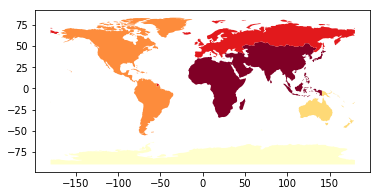

In [33]:
#aggregate populations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[['continent', 'geometry', 'pop_est']]
continents = world.dissolve(by='continent', aggfunc='sum')
continents.plot(column = 'pop_est', scheme='quantiles', cmap='YlOrRd')

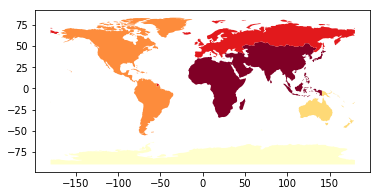

In [34]:
#output the map to a png file
continents.plot(column = 'pop_est', scheme='quantiles', cmap='YlOrRd')
plt.savefig("populations.png",format='PNG')

In [35]:
#dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# For attribute join
country_shapes = world[['geometry', 'iso_a3']]
country_names = world[['name', 'iso_a3']]

# For spatial join
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'}) #rename column "name" as "country"

In [36]:
#check country shapes
country_shapes.head()

,geometry,iso_a3
0,"POLYGON ((61.21081709172574 35.65007233330923,...",AFG
1,(POLYGON ((16.32652835456705 -5.87747039146621...,AGO
2,"POLYGON ((20.59024743010491 41.85540416113361,...",ALB
3,"POLYGON ((51.57951867046327 24.24549713795111,...",ARE
4,(POLYGON ((-65.50000000000003 -55.199999999999...,ARG


In [37]:
#check country names
country_names.head()

,name,iso_a3
0,Afghanistan,AFG
1,Angola,AGO
2,Albania,ALB
3,United Arab Emirates,ARE
4,Argentina,ARG


In [38]:
#attribute join of conntry names to country shapes and check the new country_shapes
country_shapes = country_shapes.merge(country_names, on='iso_a3')
country_shapes.head()

,geometry,iso_a3,name
0,"POLYGON ((61.21081709172574 35.65007233330923,...",AFG,Afghanistan
1,(POLYGON ((16.32652835456705 -5.87747039146621...,AGO,Angola
2,"POLYGON ((20.59024743010491 41.85540416113361,...",ALB,Albania
3,"POLYGON ((51.57951867046327 24.24549713795111,...",ARE,United Arab Emirates
4,(POLYGON ((-65.50000000000003 -55.199999999999...,ARG,Argentina


In [39]:
#check countries
countries.head()

,geometry,country
0,"POLYGON ((61.21081709172574 35.65007233330923,...",Afghanistan
1,(POLYGON ((16.32652835456705 -5.87747039146621...,Angola
2,"POLYGON ((20.59024743010491 41.85540416113361,...",Albania
3,"POLYGON ((51.57951867046327 24.24549713795111,...",United Arab Emirates
4,(POLYGON ((-65.50000000000003 -55.199999999999...,Argentina


In [40]:
#check cities
cities.head()

,name,geometry
0,Vatican City,POINT (12.45338654497177 41.90328217996012)
1,San Marino,POINT (12.44177015780014 43.936095834768)
2,Vaduz,POINT (9.516669472907267 47.13372377429357)
3,Luxembourg,POINT (6.130002806227083 49.61166037912108)
4,Palikir,POINT (158.1499743237623 6.916643696007725)


In [41]:
#spatial join cities and countries, and check the new cities_with_countries
cities_with_country = gpd.sjoin(cities, countries, how="inner", op='intersects')
cities_with_country.head()

,name,geometry,index_right,country
0,Vatican City,POINT (12.45338654497177 41.90328217996012),79,Italy
1,San Marino,POINT (12.44177015780014 43.936095834768),79,Italy
192,Rome,POINT (12.481312562874 41.89790148509894),79,Italy
2,Vaduz,POINT (9.516669472907267 47.13372377429357),9,Austria
184,Vienna,POINT (16.36469309674374 48.20196113681686),9,Austria


# A simple heat map
map layers: add crime data layer from csv, a simple heat map

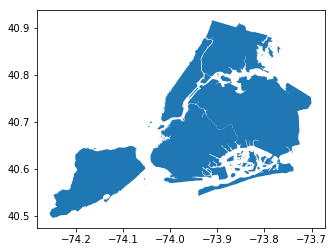

In [42]:
#read new york city geometry and plot map
new_york = gpd.GeoDataFrame.from_file("Borough Boundaries/geo_export_6b8e1e5b-bd2c-4ae6-bdfe-6580dbcd4ac2.shx")
new_york.plot()

In [43]:
#read csv file of crime data of new york
import pandas as pd
new_york_crime = pd.DataFrame.from_csv("NYPD_Complaint_Data_Historic.csv").dropna()
new_york_crime.head()

,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,...,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,
251546004,12/31/2015,22:40:00,12/31/2015,22:50:00,12/31/2015,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,...,N.Y. HOUSING POLICE,BROOKLYN,79.0,INSIDE,MARCY,998273.0,193029.0,40.696494,-73.949431,"(40.696493892, -73.949430815)"
975743412,12/31/2015,22:30:00,12/31/2015,22:45:00,12/31/2015,106,FELONY ASSAULT,106.0,"ASSAULT 2,1,PEACE OFFICER",COMPLETED,...,N.Y. HOUSING POLICE,BRONX,42.0,OPPOSITE OF,UNION AVENUE-EAST 166TH STREET,1011824.0,240352.0,40.826351,-73.900368,"(40.826351439, -73.900368274)"
824663386,12/31/2015,22:30:00,12/31/2015,23:00:00,12/31/2015,359,OFFENSES AGAINST PUBLIC ADMINI,748.0,"CONTEMPT,CRIMINAL",COMPLETED,...,N.Y. HOUSING POLICE,BRONX,42.0,INSIDE,MORRIS I,1010337.0,243009.0,40.833649,-73.905731,"(40.833648657, -73.905730918)"
372582288,12/31/2015,22:00:00,12/31/2015,22:19:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,...,N.Y. HOUSING POLICE,MANHATTAN,7.0,INSIDE,LA GUARDIA,987482.0,198516.0,40.711565,-73.988343,"(40.711564939, -73.988343369)"
834212518,12/31/2015,22:00:00,12/31/2015,22:19:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,...,N.Y. HOUSING POLICE,MANHATTAN,7.0,INSIDE,LA GUARDIA,987482.0,198516.0,40.711565,-73.988343,"(40.711564939, -73.988343369)"


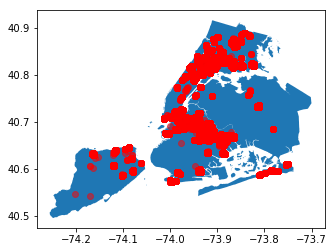

In [44]:
#plot crime data on map of new york
new_york.plot()
plt.scatter(y=new_york_crime["Latitude"], x=new_york_crime["Longitude"], alpha=0.5, c='r')